In [1]:
import numpy as np

### Research question
Is d-separation valid for intrinsic SCMs? That is, cyclic SCMs satisfiying $\rho(|A|)<1$, where $A$ is the Lipschitz matrix of the structural functions $F$?

I need methods for:
- sampling (enumerating?) from all possible cyclic graphs $G$ of size n
- sampling SCMs which fit $G$ (ideally including a mix of intrinsic and not)
- determining if an SCM $M$ is intrinsic
- constructing the graph $G$, given $M$ (unnecessary?)
- finding all d-separation statements from a cyclic graph $G$
- sampling a dataset from the observational distribution $P(V)$ of $M$
- checking whether an independence holds in the dataset from $P(V)$

Relevant resources:
- Constraint-based Causal Discovery for Non-Linear Structural Causal Models with Cycles and Latent Confounders, Mooji et. al.
- PYCID

In [2]:
import numpy as np
import helper_functions as hf
from matplotlib import pyplot as plt
import time
import networkx as nx
from tqdm import tqdm
from itertools import combinations

In [3]:
# n = 4

# collection = hf.all_graphs_fast(n)
# count_with_any_d_sep = 0
# intrinsic_pvals = []
# non_intrinsic_pvals = []

# for Adj in tqdm(collection):
#     d_seps = list(hf.all_d_separations(Adj))
#     if len(d_seps):
#         count_with_any_d_sep += 1
#         for iteration in range(1):
#             # Test non-intrinsic 
#             structure = hf.sample_neural(Adj=Adj,intrinsic=False)
#             obs_data = hf.sample_observational(structure)
#             for candidate in d_seps:
#                 pval = hf.obs_indep(candidate,obs_data,p_val=True)
#                 non_intrinsic_pvals.append(pval)
#             # Test intrinsic 
#             structure = hf.sample_neural(Adj=Adj,intrinsic=True)
#             obs_data = hf.sample_observational(structure)
#             for candidate in d_seps:
#                 pval = hf.obs_indep(candidate,obs_data,p_val=True)
#                 intrinsic_pvals.append(pval)
                
                
# print("Number of graphs:",len(collection))
# print("Number with d-separations:",count_with_any_d_sep)

In [4]:
n = 4

collection = hf.all_graphs_fast(n)
count_with_any_d_sep = 0
intrinsic_pvals = []
non_intrinsic_pvals = []
Product_pvals = []

non_got_nanned = 0
int_got_nanned = 0
prod_got_nanned = 0

num_p_vals = 10

for Adj in tqdm(collection):
    d_seps = list(hf.all_d_separations(Adj))
    if len(d_seps):
        count_with_any_d_sep += 1
        
        # Test non-intrinsic 
        structure = hf.sample_neural(Adj=Adj,intrinsic=False)
        for iteration in range(num_p_vals):
            pvals, non_got_nanned = hf.check_d_separation(structure,d_seps,non_got_nanned)
            non_intrinsic_pvals.append(pvals)
        
        # Test intrinsic 
        structure = hf.sample_neural(Adj=Adj,intrinsic=True)
        for iteration in range(num_p_vals):
            pvals, int_got_nanned = hf.check_d_separation(structure,d_seps,int_got_nanned)
            intrinsic_pvals.append(pvals)
            
#         # Test product 
#         structure = hf.product_SCM(Adj)
#         for iteration in range(num_p_vals):
#             pvals, prod_got_nanned = hf.check_d_separation(structure,d_seps,prod_got_nanned)
#             Product_pvals.append(pvals)

100%|██████████| 216/216 [15:43:48<00:00, 262.17s/it]  


In [5]:
print("Number of graphs:",len(collection))
print("Number with d-separations:",count_with_any_d_sep)
print("Non-intrinsic, didn't converge:",non_got_nanned)
print("Intrinsic, didn't converge:",int_got_nanned)
print("Product, didn't converge:",prod_got_nanned)

Number of graphs: 216
Number with d-separations: 107
Non-intrinsic, didn't converge: 0
Intrinsic, didn't converge: 0
Product, didn't converge: 0


In [8]:
# intrinsic_pvals
# non_intrinsic_pvals

def extract_data(all_pvals,num_p_vals):
    data = dict()
    i = -1
    for Adj in collection:
        d_seps = list(hf.all_d_separations(Adj))
        if len(d_seps):
            i += 1
            assert i >= 0
            assert i <= 107
            relevant_p_vals = all_pvals[i*num_p_vals:(i+1)*num_p_vals]
            assert len(relevant_p_vals) == num_p_vals

            Adj_d_seps = dict()
            for p_vals in relevant_p_vals: # each item here is pvals-output of check_d_separation()
                for j, candidate in enumerate(d_seps):
                    assert p_vals[j][0] == candidate
                    pval = p_vals[j][1]
                    if candidate in Adj_d_seps.keys():
                        Adj_d_seps[candidate].append(pval)
                    else:
                        Adj_d_seps[candidate] = [pval,]

            Adj_data = [Adj,Adj_d_seps]
            data[i] = Adj_data
    return data

In [9]:
intrinsic_data = extract_data(intrinsic_pvals,num_p_vals)
non_intrinsic_data = extract_data(non_intrinsic_pvals,num_p_vals)
# product_data = extract_data(Product_pvals,num_p_vals)

In [12]:
import pickle

pickle.dump( intrinsic_data, open( "intrinsic_data.p", "wb" ) )
pickle.dump( non_intrinsic_data, open( "non_intrinsic_data.p", "wb" ) )

In [10]:
def plot(candidate,int_pvals,non_pvals,prod_pvals=None):
    X,Y,Z = candidate
    plt.rcParams.update({'font.size': 22})

    plt.figure(figsize=(3,1))
#     plt.hist(prod_pvals,label="product",alpha=0.5,color='r',bins=20)
    plt.hist(non_pvals,label="lipschitz",alpha=0.5,color='b',bins=20)
    plt.hist(int_pvals,label="intrinsic",alpha=0.5,color='g',bins=20)
#     plt.hist(pvals,bins=20)
    plt.axis([0, 1, 0, 5])
    plt.xlabel("P-value (fcit)")
    plt.ylabel("freq")
    plt.title("$({} \perp \!\!\! \perp {} | {})$ ?".format(X,Y,Z))
    plt.show()

0
[[0 1 0 0]
 [1 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
1
[[0 1 0 0]
 [0 0 0 0]
 [0 1 0 0]
 [0 0 0 0]]
2
[[0 1 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 0 0]]
3
[[0 1 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 1 0]]
4
[[0 1 0 0]
 [1 0 0 0]
 [0 0 0 0]
 [0 0 1 0]]
5
[[0 1 0 0]
 [0 0 0 0]
 [0 1 0 0]
 [0 0 1 0]]
0.36411079672362057
something happened


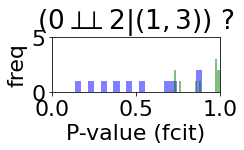

6
[[0 1 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]]
7
[[0 1 0 0]
 [0 0 0 0]
 [1 0 0 0]
 [0 0 0 0]]
8
[[0 1 0 0]
 [0 0 0 0]
 [1 1 0 0]
 [0 0 0 0]]
9
[[0 1 0 0]
 [1 0 0 0]
 [1 1 0 0]
 [0 0 0 0]]
10
[[0 1 0 0]
 [0 0 0 0]
 [1 0 0 0]
 [0 0 1 0]]
11
[[0 1 0 0]
 [0 0 0 0]
 [1 1 0 0]
 [0 0 1 0]]
12
[[0 1 0 0]
 [1 0 0 0]
 [1 1 0 0]
 [0 0 1 0]]
13
[[0 1 0 0]
 [0 0 0 0]
 [0 1 0 0]
 [0 1 0 0]]
14
[[0 1 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]]
15
[[0 1 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 1 1 0]]
16
[[0 1 0 0]
 [1 0 0 0]
 [0 0 0 0]
 [0 1 1 0]]
17
[[0 1 0 0]
 [0 0 0 0]
 [0 1 0 0]
 [0 1 1 0]]
18
[[0 1 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 1 0]]
19
[[0 1 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]]
20
[[0 1 0 0]
 [1 0 0 0]
 [1 1 0 0]
 [0 1 0 0]]
21
[[0 1 0 0]
 [0 0 0 0]
 [1 0 0 0]
 [0 1 1 0]]
22
[[0 1 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 1 0]]
23
[[0 1 0 0]
 [0 0 0 0]
 [1 1 0 0]
 [0 1 1 0]]
24
[[0 1 0 0]
 [1 0 0 0]
 [1 1 0 0]
 [0 1 1 0]]
25
[[0 1 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [1 0 1 0]]
26
[[0 1 0 0]
 [0 0 0 0]
 [0 1 0 0]
 [1 0 1 

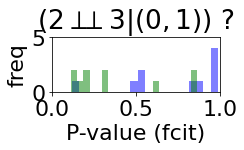

40
[[0 0 0 0]
 [1 0 1 0]
 [0 1 0 0]
 [0 0 1 0]]
41
[[0 0 0 0]
 [1 0 1 0]
 [1 1 0 0]
 [0 0 0 0]]
42
[[0 0 0 0]
 [0 0 1 0]
 [1 1 0 0]
 [0 0 1 0]]
43
[[0 0 0 0]
 [1 0 1 0]
 [1 1 0 0]
 [0 0 1 0]]
44
[[0 0 0 0]
 [1 0 1 0]
 [0 0 0 0]
 [0 1 0 0]]
45
[[0 0 0 0]
 [1 0 1 0]
 [0 0 0 0]
 [0 1 1 0]]
46
[[0 0 0 0]
 [1 0 1 0]
 [0 1 0 0]
 [0 1 1 0]]
47
[[0 0 0 0]
 [1 0 1 0]
 [1 1 0 0]
 [0 1 1 0]]
48
[[0 0 0 0]
 [1 0 1 0]
 [0 1 0 0]
 [1 0 0 0]]
49
[[0 0 0 0]
 [1 0 1 0]
 [0 0 0 0]
 [1 0 1 0]]
50
[[0 0 0 0]
 [1 0 1 0]
 [0 1 0 0]
 [1 0 1 0]]
51
[[0 0 0 0]
 [1 0 1 0]
 [1 1 0 0]
 [1 0 0 0]]
52
[[0 0 0 0]
 [0 0 1 0]
 [1 1 0 0]
 [1 0 1 0]]
53
[[0 0 0 0]
 [1 0 1 0]
 [1 1 0 0]
 [1 0 1 0]]
54
[[0 0 0 0]
 [1 0 1 0]
 [0 0 0 0]
 [1 1 1 0]]
55
[[0 1 0 0]
 [1 0 1 0]
 [0 1 0 0]
 [0 0 0 0]]
56
[[0 1 0 0]
 [1 0 1 0]
 [0 1 0 0]
 [0 0 1 0]]
57
[[0 1 0 0]
 [0 0 1 0]
 [1 0 0 0]
 [0 0 0 0]]
58
[[0 1 0 0]
 [1 0 1 0]
 [1 0 0 0]
 [0 0 0 0]]
0.38528793341714973
something happened


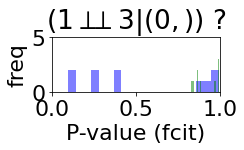

59
[[0 1 0 0]
 [1 0 1 0]
 [1 1 0 0]
 [0 0 0 0]]
60
[[0 1 0 0]
 [0 0 1 0]
 [1 0 0 0]
 [0 0 1 0]]
61
[[0 1 0 0]
 [1 0 1 0]
 [1 0 0 0]
 [0 0 1 0]]
62
[[0 1 0 0]
 [0 0 1 0]
 [1 1 0 0]
 [0 0 1 0]]
63
[[0 1 0 0]
 [1 0 1 0]
 [1 1 0 0]
 [0 0 1 0]]
64
[[0 1 0 0]
 [1 0 1 0]
 [0 1 0 0]
 [0 1 0 0]]
65
[[0 1 0 0]
 [1 0 1 0]
 [0 1 0 0]
 [0 1 1 0]]
66
[[0 1 0 0]
 [0 0 1 0]
 [1 1 0 0]
 [0 1 0 0]]
67
[[0 1 0 0]
 [1 0 1 0]
 [1 1 0 0]
 [0 1 0 0]]
68
[[0 1 0 0]
 [0 0 1 0]
 [1 0 0 0]
 [0 1 1 0]]
69
[[0 1 0 0]
 [1 0 1 0]
 [1 0 0 0]
 [0 1 1 0]]
70
[[0 1 0 0]
 [0 0 1 0]
 [1 1 0 0]
 [0 1 1 0]]
71
[[0 1 0 0]
 [1 0 1 0]
 [1 1 0 0]
 [0 1 1 0]]
72
[[0 1 0 0]
 [1 0 1 0]
 [0 1 0 0]
 [1 0 1 0]]
73
[[0 1 0 0]
 [1 0 1 0]
 [1 1 0 0]
 [1 0 0 0]]
74
[[0 1 0 0]
 [1 0 1 0]
 [1 0 0 0]
 [1 0 1 0]]
75
[[0 1 0 0]
 [1 0 1 0]
 [1 1 0 0]
 [1 0 1 0]]
76
[[0 1 0 0]
 [1 0 1 0]
 [1 1 0 0]
 [1 1 0 0]]
77
[[0 0 0 0]
 [1 0 0 0]
 [0 1 0 1]
 [0 0 1 0]]
78
[[0 0 0 0]
 [0 0 0 0]
 [1 1 0 1]
 [0 0 0 0]]
79
[[0 0 0 0]
 [1 0 0 0]
 [0 1 0 1]
 [0 

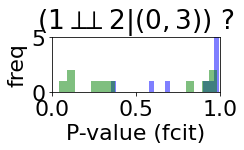

82
[[0 1 0 0]
 [1 0 0 0]
 [0 1 0 1]
 [0 0 1 0]]
83
[[0 1 0 0]
 [1 0 0 0]
 [0 1 0 1]
 [0 1 1 0]]
84
[[0 0 0 0]
 [1 0 1 0]
 [0 1 0 1]
 [0 0 1 0]]
85
[[0 0 0 0]
 [1 0 1 0]
 [0 0 0 1]
 [0 1 0 0]]
86
[[0 0 0 0]
 [1 0 1 0]
 [0 1 0 1]
 [0 1 0 0]]
87
[[0 0 0 0]
 [1 0 1 0]
 [0 0 0 1]
 [0 1 1 0]]
88
[[0 0 0 0]
 [1 0 1 0]
 [0 1 0 1]
 [0 1 1 0]]
89
[[0 1 0 0]
 [1 0 1 0]
 [0 1 0 1]
 [0 0 1 0]]
90
[[0 1 0 0]
 [0 0 1 0]
 [1 0 0 1]
 [0 0 1 0]]
91
[[0 1 0 0]
 [1 0 1 0]
 [1 0 0 1]
 [0 0 1 0]]
92
[[0 1 0 0]
 [1 0 1 0]
 [0 1 0 1]
 [0 1 0 0]]
93
[[0 1 0 0]
 [1 0 1 0]
 [0 1 0 1]
 [0 1 1 0]]
94
[[0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [1 0 0 0]]
95
[[0 1 0 0]
 [1 0 1 0]
 [0 0 0 1]
 [1 0 0 0]]
96
[[0 1 0 0]
 [1 0 1 0]
 [0 0 0 1]
 [1 0 1 0]]
97
[[0 1 0 0]
 [0 0 1 0]
 [1 0 0 1]
 [1 0 0 0]]
98
[[0 1 0 0]
 [1 0 1 0]
 [1 0 0 1]
 [1 0 0 0]]
99
[[0 1 0 0]
 [0 0 1 0]
 [1 0 0 1]
 [1 0 1 0]]
100
[[0 1 0 0]
 [1 0 1 0]
 [1 0 0 1]
 [1 0 1 0]]
101
[[0 1 1 0]
 [1 0 1 0]
 [1 1 0 0]
 [0 0 0 0]]
102
[[0 1 1 0]
 [1 0 1 0]
 [1 1 0 0]
 

In [19]:
for key, (Adj,Adj_d_seps) in intrinsic_data.items():
    print(key)
    print(Adj)
    
    (nAdj,nAdj_d_seps) = non_intrinsic_data[key]
#     (pAdj,pAdj_d_seps) = product_data[key]
    assert np.allclose(Adj,nAdj)
#     assert np.allclose(Adj,pAdj)
    
    for candidate, int_pvals in Adj_d_seps.items():
        non_pvals = nAdj_d_seps[candidate]
#         prod_pvals = pAdj_d_seps[candidate]
        if np.mean(int_pvals) <= .1 or np.mean(non_pvals) <= .1: # here. need to incorperate product checks.
            plot(candidate,int_pvals,non_pvals)
            print(np.mean(int_pvals)-np.mean(non_pvals))
            print(int_pvals)
            time.sleep(1)
        try:
            assert np.mean(int_pvals) > .1
            assert np.mean(non_pvals) > .1
            assert np.abs(np.mean(int_pvals)-np.mean(non_pvals)) < 0.35, np.abs(np.mean(int_pvals)-np.mean(non_pvals))
        except AssertionError as E:
            print(E)
            print("something happened")
            plot(candidate,int_pvals,non_pvals)
            time.sleep(1)
#         if np.mean(prod_pvals) <= .2:
#             plot(candidate,int_pvals,non_pvals)
#             print("product is small")
#             print(prod_pvals)